# combined models

It is possible to combine scattering models with simple arithmetic functions which can be useful for systems in which multiple scattering particles or structures are expected. In this example, we look at a system containing both sphere and cylinder particles.

In [1]:
from bumps.names import Parameter, inf
from bumps.fitters import fit

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sasmodels
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment

import bumps

# uncomment and edit line below to add path to the sasview source code
# sys.path.append("/path/to/sasview/src")
import sas

Let's use an example where we collected data for a sample using both SANS and USANS instrumentation. In this case, the USANS data has already been 'de-smeared' and we see good aggregment across the full range of q-values.

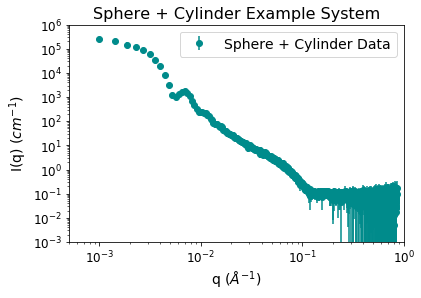

In [3]:
data_np = np.loadtxt('../example_data/sphere_cylinder.csv',delimiter=',')
mask = np.where(data_np[:,1]>0)[0] # removing points that may be below zero due to noise
data = sasmodels.data.Data1D(x=data_np[mask,0], y=data_np[mask,1], dy=data_np[mask,2])

plt.errorbar(data.x, data.y, yerr=data.dy, fmt='o', color='darkcyan', label='Sphere + Cylinder Data')

# x-axis
plt.xlim(5e-4,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e6)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('Sphere + Cylinder Example System',fontsize=16)
plt.legend(fontsize=14)

plt.show()

We start by setting up the kernel and model as we normally would for a single system, however, we modify the loaded model to include both sphere and cylinder form factors. We can do this by simply using basic arithmetic symbols in the string. The parameters now look a little different before. The "A_" parameters are attributed to the sphere phase and the "B_" parameters are attributed to the cylinder (these go in order as specified). There is also now an overall scaling factor and background. In this example, these models are combined as:

I(q) = scale * (A_scale * A_form_factor + B_scale * B_form_factor) + background

In [5]:
kernel = sasmodels.core.load_model("sphere+cylinder")
Model(model=kernel).parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'A_scale': Parameter(A_scale),
 'A_sld': Parameter(A_sld),
 'A_sld_solvent': Parameter(A_sld_solvent),
 'A_radius': Parameter(A_radius),
 'A_radius_pd': Parameter(A_radius_pd),
 'A_radius_pd_n': Parameter(A_radius_pd_n),
 'A_radius_pd_nsigma': Parameter(A_radius_pd_nsigma),
 'B_scale': Parameter(B_scale),
 'B_sld': Parameter(B_sld),
 'B_sld_solvent': Parameter(B_sld_solvent),
 'B_radius': Parameter(B_radius),
 'B_radius_pd': Parameter(B_radius_pd),
 'B_radius_pd_n': Parameter(B_radius_pd_n),
 'B_radius_pd_nsigma': Parameter(B_radius_pd_nsigma),
 'B_length': Parameter(B_length),
 'B_length_pd': Parameter(B_length_pd),
 'B_length_pd_n': Parameter(B_length_pd_n),
 'B_length_pd_nsigma': Parameter(B_length_pd_nsigma),
 'B_theta': Parameter(B_theta),
 'B_theta_pd': Parameter(B_theta_pd),
 'B_theta_pd_n': Parameter(B_theta_pd_n),
 'B_theta_pd_nsigma': Parameter(B_theta_pd_nsigma),
 'B_phi': Parameter(B_phi),
 'B_phi_pd': Param

We will similarly setup the model, but now accounting for both sphere and cylinder phases. It is worth noting that the scale paraemters can also now be used to help balance the presence of both of these structures. For example, if we knew the total volume fraction of the phase that is present in either a sphere or cylinder shape, we could set the overall scale parameter at that specified value. Then, A_scale can be set with an initial guess such as 0.2, i.e. 20% of the scattering phase is present in the spherical structures. Parameters can also be related to each other with mathematical transformations, and so B_scale can be defined as 1-A_scale to maintain mass balance.

final chisq 6.8120(36)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                           sphere radius 803.93(61)      803.93(23)     
                         sphere fraction 0.78835(54)     0.78835(21)    
                         cylinder length 226.25(85)      226.25(33)     
                         cylinder radius 31.452(13)      31.4520(51)    
                   incoherent background 0.079941(13)    0.0799412(51)  
                                   scale 0.06297(12)     0.062973(44)   


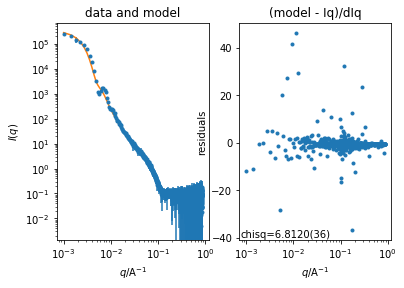

In [12]:
kernel = sasmodels.core.load_model("sphere+cylinder")

scale = Parameter(0.07, name='scale').range(0,1) # setting our fitting range to (0,1)
background = Parameter(0.01, name='incoherent background').range(0,1)

# scattering length densities for our scattering particles and solvent
sld = Parameter(0.728, name='sld')
sld_solvent = Parameter(5.238, name='sld solvent')

A_scale = Parameter(0.2, name='sphere fraction').range(0,1)
A_radius = Parameter(4000, limits=(0,inf), name='sphere radius').range(0,5000)
A_radius_pd = Parameter(0.2, limits=(0,inf))
A_radius_pd_type = 'lognormal'

B_scale = 1 - A_scale
B_radius = Parameter(10, limits=(0,inf), name='cylinder radius').range(0,5000)
B_radius_pd = Parameter(0, limits=(0,inf))
B_radius_pd_type = 'lognormal'

B_length = Parameter(238, limits=(0,inf), name='cylinder length').range(0,5000)
B_length_pd = Parameter(0, limits=(0,inf))
B_length_pd_type = 'lognormal'

model = Model(model=kernel,
             scale=scale,
             background=background,
             A_scale=A_scale,
             B_scale=B_scale,
             A_sld=sld,
             A_sld_solvent=sld_solvent,
             B_sld=sld,
             B_sld_solvent=sld_solvent,
             A_radius=A_radius,
             A_radius_pd=A_radius_pd,
             A_radius_pd_type=A_radius_pd_type,
             B_radius=B_radius,
             B_radius_pd=B_radius_pd,
             B_radius_pd_type=B_radius_pd_type,
             B_length=B_length,
             B_length_pd=B_length_pd,
             B_length_pd_type=B_length_pd_type,
             )

experiment = sasmodels.bumps_model.Experiment(data=data, model=model)
problem = bumps.fitproblem.FitProblem(experiment)
results = bumps.fitters.fit(problem, method='lm', verbose=True)
problem.plot()

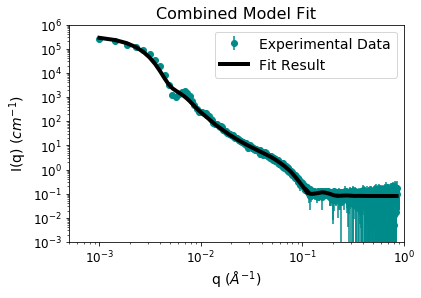

In [14]:
plt.errorbar(data.x, data.y, yerr=data.dy, fmt='o', color='darkcyan', label='Experimental Data')

plt.errorbar(data.x, problem.fitness.theory(), fmt='-', color='black', label='Fit Result', linewidth=4)


# x-axis
plt.xlim(5e-4,1e0)
plt.xscale('log')
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=12)

# y-axis
plt.ylim(1e-3,1e6)
plt.yscale('log')
plt.ylabel('I(q) ($cm^{-1}$)',fontsize=14)
plt.yticks(fontsize=12)

plt.title('Combined Model Fit',fontsize=16)
plt.legend(fontsize=14)

plt.show()